## Machine Learning

In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from tqdm import tqdm

from anngel.datasets.custom_dataset import CustomDataset

In [15]:
# CHANGE HERE
output_dir_4 = Path('./4_outputs/standard/')
output_dir_4_standard = Path('./4_outputs/standard/')
output_dir_4_small_ds = Path('./4_outputs/small_DS/')
output_dir_5_standard = Path('./5_outputs/standard_reduced')
output_dir_5_small_ds = Path('./5_outputs/small_DS_reduced')
output_dirs_5_standard = [Path(f'./5_outputs/standard_reduced_{i}/') for i in range(10)]
output_dirs_5_small_ds = [Path(f'./5_outputs/small_DS_reduced_{i}/') for i in range(10)]
# ----

output_dir_5_standard.mkdir(exist_ok=True)
output_dir_5_small_ds.mkdir(exist_ok=True)

ds = CustomDataset("./tmp", dataset_name='enriched_opnbiolink')

In [3]:
def load_outputs_5(output_dir_4, output_dir_5):
    xy_dir = output_dir_4 / 'XY_reduced'
    train_dir = xy_dir / 'train'
    val_dir = xy_dir / 'val'
    test_dir = xy_dir / 'test'

    y_train_file = train_dir / 'y.csv'
    y_val_file = val_dir / 'y.csv'
    y_test_file = test_dir / 'y.csv'

    X_train_files = [f for f in train_dir.glob('*.csv') if not f.name == 'y.csv']
    X_val_files = [val_dir / f.name for f in X_train_files]
    X_test_files = [test_dir / f.name for f in X_train_files]

    def evaluate(m, X, y, n=100, scale=True):
        y_pred = m.predict(X) > 0
        y_prob_pred = m.predict_proba(X)

        order = np.argsort(y_prob_pred)[::-1]
        # print(y_pred[order][:n])
        if scale:
            return y[order][:n].sum() / y.sum()
        else:
            return y[order][:n].sum()

    def calc_metrics(y_pred, y_true):
        return {
            "f1": f1_score(y_pred=y_pred, y_true=y_true),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
            "precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "confusion_matrix": confusion_matrix(y_pred=y_pred, y_true=y_true),
        }

    r = {}

    proba_dfs = {}
    Xs = {}
    y_dfs = {}
    ys = {}
    indices={}
    for ds in ('train', 'val', 'test'):
        proba_df = pd.read_csv(output_dir_5 / f'{ds}_probabilities.csv', index_col=0)
        proba_dfs[ds] = proba_df
        y_df = pd.read_csv(xy_dir / f'{ds}/y.csv', index_col=0)
        y_dfs[ds] = y_df

        X = proba_df.values
        Xs[ds] = X
        y = y_df.iloc[:, 0].values
        ys[ds] = y

        indices[ds] = proba_df.index

    feature_names = proba_dfs['train'].columns.values

    lr_file = output_dir_5 / 'lr.pkl'
    with open(lr_file, 'rb') as f:
        lr = pickle.load(f)


    r['proba_dfs'] = proba_dfs
    r['feature_names'] = feature_names
    r['lr'] = lr

    y_val_pred = lr.predict(Xs['val'])
    r['val_metrics'] = calc_metrics(y_pred=y_val_pred, y_true=ys['val'])

    y_test_pred = lr.predict(Xs['test'])
    r['test_metrics'] = calc_metrics(y_pred=y_test_pred, y_true=ys['test'])

    y_test_prob = lr.predict_proba(Xs['test'])
    y_test_pred = lr.predict(Xs['test'])

    tmp_df = pd.DataFrame(y_test_prob, index=indices['test'])
    tmp_df['irr'] = ys['test']
    tmp_df_sorted = tmp_df.sort_values(0, ascending=True)
    r['tmp_df'] = tmp_df
    r['tmp_df_sorted'] = tmp_df_sorted

    n_top = 100
    hits_100 = tmp_df_sorted.iloc[:n_top]['irr'].sum()
    r['hits_100'] = hits_100

    n_top = 10
    hits_10 = tmp_df_sorted.iloc[:n_top]['irr'].sum()
    r['hits_10'] = hits_10
    
    
    y_train_prob = lr.predict_proba(Xs['train'])
    y_val_prob = lr.predict_proba(Xs['val'])
    y_test_prob = lr.predict_proba(Xs['test'])
    
    y_prob = np.r_[y_train_prob, y_val_prob, y_test_prob][:,1]
    y = np.r_[ys['train'], ys['val'], ys['test']]
    
    index = np.r_[indices['train'], indices['val'], indices['test']]

    train_idcs = np.arange(len(y_train_prob))
    val_idcs = np.arange(len(y_train_prob), len(y_train_prob) + len(y_val_prob))
    test_idcs = np.arange(len(y_train_prob) + len(y_val_prob), len(y_train_prob) + len(y_val_prob) + len(y_test_prob))

    proba_df = pd.DataFrame({'probability': y_prob, 'irr': y}, index=index)
    proba_df['train'] = False
    proba_df.iloc[train_idcs, 2] = True
    proba_df['val'] = False
    proba_df.iloc[val_idcs, 3] = True
    proba_df['test'] = False
    proba_df.iloc[test_idcs, 4] = True

    r['proba_df'] = proba_df
    
    return r

In [4]:
rs_standard = [load_outputs_5(output_dir_4_standard, d) for d in output_dirs_5_standard]
rs_small_ds = [load_outputs_5(output_dir_4_small_ds, d) for d in output_dirs_5_small_ds]

hits_100_standard = [r['hits_100'] for r in rs_standard]
hits_10_standard = [r['hits_10'] for r in rs_standard]
hits_100_small_ds = [r['hits_100'] for r in rs_small_ds]
hits_10_small_ds = [r['hits_10'] for r in rs_small_ds]

hits_df = pd.DataFrame({
    'model_name': ['standard'] * len(hits_100_standard) + ['small_ds'] * len(hits_100_small_ds),
    'hits_100': [*hits_100_standard, *hits_100_small_ds],
    'hits_10': [*hits_10_standard, *hits_10_small_ds],
})

In [5]:
def build_proba_df_all(rs):
    from anngel.datasets.openbiolink import OpenBioLinkDataset

    ds = OpenBioLinkDataset("./tmp/openbiolink/")
    nodes_df = ds.get_nodes()

    proba_df_all = rs[0]['proba_df']
    proba_df_all = proba_df_all.drop('probability', axis=1)

    for i, r in enumerate(rs):
        proba_df = r['proba_df']
        proba_df_all[f'Topology_{i}'] = proba_df['probability']

    proba_df_all = proba_df_all.sort_index()
    proba_df_all = proba_df_all[~proba_df_all.index.duplicated(keep='first')]
    proba_df_all = proba_df_all.join(nodes_df)
    
    gene_mapping_df = pd.read_csv('./data/gene_df.csv')
    gene_mapping_df['node_id'] = [f'NCBIGENE:{i}' for i in gene_mapping_df['gene_label']]
    gene_mapping_df = gene_mapping_df[['node_id', 'gene_name']]
    gene_map = {node_id: gene_name for _, (node_id, gene_name) in gene_mapping_df.iterrows()}
    proba_df_all['gene_name'] = [gene_map[node_id] for node_id in proba_df_all['node_id']]
    
    proba_df_all = proba_df_all.drop('node_type', axis=1)
    proba_df_all = proba_df_all[['node_id', 'gene_name', 'irr', 'train', 'val', 'test', *[c for c in proba_df_all.columns if c.startswith('Topology_')]]]
    
    return proba_df_all

In [16]:
proba_df_all_large = build_proba_df_all(rs_standard)
proba_df_all_small = build_proba_df_all(rs_small_ds)

proba_df_all_large.to_csv(output_dir_5_standard / 'proba_df.csv')
proba_df_all_large.query('test').to_csv(output_dir_5_standard / 'proba_df_test.csv')
proba_df_all_small.to_csv(output_dir_5_small_ds / 'proba_df.csv')
proba_df_all_small.query('test').to_csv(output_dir_5_small_ds / 'proba_df_test.csv')

In [17]:
proba_df_all_large.sort_values('Topology_0', ascending=False).query('test').iloc[:100,:]['irr'].sum()

19

In [18]:
proba_df_all_small.sort_values('Topology_0', ascending=False).query('test').iloc[:100,:]['irr'].sum()

5

In [19]:
proba_df_all_large = pd.read_csv(output_dir_5_standard / 'proba_df.csv', index_col=0)
proba_df_all_small = pd.read_csv(output_dir_5_small_ds / 'proba_df.csv', index_col=0)

In [20]:
proba_df_all_large.sort_values('Topology_0', ascending=False).query('test')

,node_id,gene_name,irr,train,val,test,Topology_0,Topology_1,Topology_2,Topology_3,Topology_4,Topology_5,Topology_6,Topology_7,Topology_8,Topology_9
116136,NCBIGENE:5702,PSMC3,False,False,False,True,0.943218,0.941135,0.944858,0.940150,0.946483,0.943607,0.946501,0.943606,0.945444,0.945294
104479,NCBIGENE:109,ADCY3,False,False,False,True,0.899925,0.891810,0.911770,0.906337,0.894996,0.906687,0.904149,0.884961,0.889610,0.897229
110586,NCBIGENE:2967,GTF2H3,False,False,False,True,0.886081,0.845648,0.843735,0.866427,0.866440,0.873583,0.879555,0.870720,0.868666,0.862958
114061,NCBIGENE:51343,FZR1,False,False,False,True,0.882786,0.884655,0.858299,0.904063,0.896299,0.873125,0.890002,0.904773,0.904636,0.897480
111068,NCBIGENE:3360,HTR4,False,False,False,True,0.859910,0.842277,0.835115,0.875342,0.828191,0.846977,0.867341,0.832118,0.836753,0.852648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110385,NCBIGENE:286527,TMSB15B,False,False,False,True,0.000095,0.000096,0.000094,0.000094,0.000095,0.000096,0.000098,0.000094,0.000094,0.000102
111436,NCBIGENE:347468,OR13H1,False,False,False,True,0.000095,0.000096,0.000094,0.000094,0.000095,0.000096,0.000095,0.000094,0.000094,0.000094
111686,NCBIGENE:3676,ITGA4,False,False,False,True,0.000092,0.000093,0.000093,0.000088,0.000089,0.000097,0.000093,0.000087,0.000091,0.000089
104306,NCBIGENE:10692,RRH,False,False,False,True,0.000085,0.000086,0.000085,0.000084,0.000085,0.000086,0.000085,0.000084,0.000085,0.000085


In [21]:
def build_ranked_lists(proba_df, prefix='Topology'):
    gene_lists = {}
    for i in range(10):
        col_nm = f'{prefix}_{i}'
        genes_100 = proba_df[['gene_name', col_nm]].sort_values(col_nm, ascending=False).iloc[:100]['gene_name'].values
        gene_lists[col_nm] = genes_100

    return pd.DataFrame(gene_lists)

In [22]:
genes_100_large = build_ranked_lists(proba_df_all_large)
genes_100_large_test = build_ranked_lists(proba_df_all_large.query('test'))
genes_100_small = build_ranked_lists(proba_df_all_small)
genes_100_small_test = build_ranked_lists(proba_df_all_small.query('test'))

In [23]:
genes_100_large.to_csv(output_dir_5_standard / 'genes_100.csv', index=False)
genes_100_large_test.to_csv(output_dir_5_standard / 'genes_100_test.csv', index=False)
genes_100_small.to_csv(output_dir_5_small_ds / 'genes_100.csv', index=False)
genes_100_small_test.to_csv(output_dir_5_small_ds / 'genes_100_test.csv', index=False)

In [24]:
from sklearn.metrics import confusion_matrix
from anngel.metrics import mr_on_proba_df, mrr_on_proba_df, amri_on_proba_df

from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

def calc_scores(proba_df, prefix='Topology', th=0.5):
    columns = {
        'model_name': [],
        'hits@10': [],
        'hits@100': [],
        'mr': [],
        'mrr': [],
        'amri': [],
        'tp': [],
        'fp': [],
        'fn': [],
        'tn': [],
    }
    for i in range(10):
        col_nm = f'{prefix}_{i}'
        columns['model_name'].append(col_nm)

        tmp_df = proba_df[['irr', col_nm]].sort_values(col_nm, ascending=False)
        columns['hits@10'].append(tmp_df.iloc[:10]['irr'].sum())
        columns['hits@100'].append(tmp_df.iloc[:100]['irr'].sum())
        columns['mr'].append(mr_on_proba_df(proba_df, colname_scores=col_nm, colname_y='irr'))
        columns['mrr'].append(mrr_on_proba_df(proba_df, colname_scores=col_nm, colname_y='irr'))
        columns['amri'].append(amri_on_proba_df(proba_df, colname_scores=col_nm, colname_y='irr'))
        
        cmat = sklearn_confusion_matrix(y_true=tmp_df['irr'], y_pred=tmp_df[col_nm] > th)
        columns['tp'].append(cmat[0, 0])
        columns['fp'].append(cmat[0, 1])
        columns['fn'].append(cmat[1, 0])
        columns['tn'].append(cmat[1, 1])

    score_df = pd.DataFrame(columns)
    score_df = score_df.set_index('model_name').T
    score_df = score_df.reset_index().rename({'index': 'score'}, axis=1)
    score_df['mean'] = score_df.mean(axis=1)
    
    return score_df

In [40]:
score_df_large_all = calc_scores(proba_df_all_large)
score_df_large_test = calc_scores(proba_df_all_large.query('test'))
score_df_large_all.to_csv(output_dir_5_standard / 'scores.csv', index=False)
score_df_large_test.to_csv(output_dir_5_standard / 'scores_test.csv', index=False)

score_df_small_all = calc_scores(proba_df_all_small)
score_df_small_test = calc_scores(proba_df_all_small.query('test'))
score_df_small_all.to_csv(output_dir_5_small_ds / 'scores.csv', index=False)
score_df_small_test.to_csv(output_dir_5_small_ds / 'scores_test.csv', index=False)

/tmp/ipykernel_35730/36169545.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_df['mean'] = score_df.mean(axis=1)
/tmp/ipykernel_35730/36169545.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_df['mean'] = score_df.mean(axis=1)
/tmp/ipykernel_35730/36169545.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  score_df['mean'] = score_df.mean(axis=1)
/tmp/ipykernel_35730/36169545.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeri

In [ ]:
# s3_prefix = "s3://nnedl-core-prd-eu-central-1-curated/compbiosandbox/Projects/NNRCO_KG/Sprint_3_3_IR_Paper/Result_lists"
# method = "Topology"
# graph = "enrichedOBL"

# ts = "LargeTS"
# subset = "WholeSet"
# !aws s3 cp './5_outputs/standard/proba_df.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
# !aws s3 cp './5_outputs/standard/genes_100.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
# !aws s3 cp './5_outputs/standard/scores.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv
# subset = "TestSet"
# !aws s3 cp './5_outputs/standard/proba_df_test.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
# !aws s3 cp './5_outputs/standard/genes_100_test.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
# !aws s3 cp './5_outputs/standard/scores_test.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv

# ts = "SmallTS"
# subset = "WholeSet"
# !aws s3 cp './5_outputs/small_DS/proba_df.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
# !aws s3 cp './5_outputs/small_DS/genes_100.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
# !aws s3 cp './5_outputs/small_DS/scores.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv
# subset = "TestSet"
# !aws s3 cp './5_outputs/small_DS/proba_df_test.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/all_results.csv
# !aws s3 cp './5_outputs/small_DS/genes_100_test.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/gene_100.csv
# !aws s3 cp './5_outputs/small_DS/scores_test.csv' {s3_prefix}/{graph}/{ts}/{method}/{subset}/scores.csv

# !aws s3 ls --recursive {s3_prefix}

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

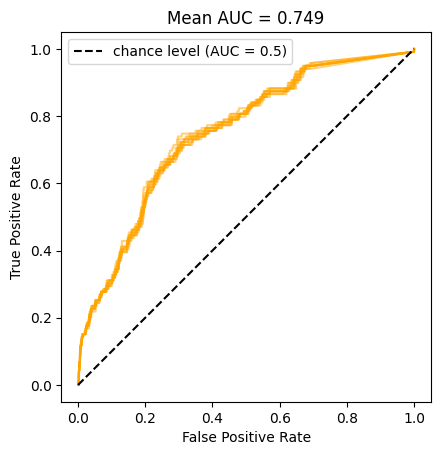

In [27]:
roc_curves = []
aucs = []
for r in rs_standard:
    df = r['tmp_df']
    y_score = df[1]
    y_true = df['irr']

    fpr, tpr, ths = roc_curve(y_true=y_true, y_score=y_score, drop_intermediate=False)
    roc_curves.append((fpr, tpr, ths))
    aucs.append(auc(fpr, tpr))
    
fig = plt.figure()
for fpr, tpr, _ in roc_curves:
    plt.plot(fpr, tpr, color='orange', alpha=0.5)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f'Mean AUC = {round(np.mean(aucs), 3)}')
plt.legend()
plt.show()
fig.savefig(Path('5_outputs/standard') / 'ROC_curve.png', dpi=300)

In [28]:
def get_cmat_df(rs):
    cmats = [r['test_metrics']['confusion_matrix'] for r in rs]
    cmat_df = pd.DataFrame(np.array(cmats).mean(axis=0), columns=('Positive', 'Negative'), index=('Positive', 'Negative'))
    return cmat_df, cmats

In [29]:
cmat_df_standard, cmats_standard = get_cmat_df(rs_standard)
cmat_df_small, cmats_small = get_cmat_df(rs_small_ds)

In [30]:
cmat_df_standard.to_csv('./5_outputs/standard/cmat.csv')
cmat_df_small.to_csv('./5_outputs/small_DS/cmat.csv')

In [31]:
cmat_df_standard

,Positive,Negative
Positive,3785.5,10.5
Negative,114.0,5.0


In [32]:
cmat_df_small

,Positive,Negative
Positive,3863.0,0.0
Negative,119.0,0.0


In [33]:
hits_df.groupby('model_name').mean()

,hits_100,hits_10
model_name,,
small_ds,5.0,0.0
standard,18.5,1.9


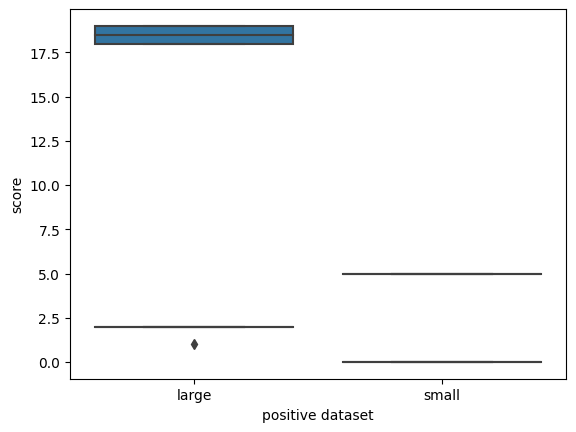

In [34]:
import seaborn as sns
sns.boxplot(hits_df, x='model_name', y='hits_100')
plot = sns.boxplot(hits_df, x='model_name', y='hits_10')
plot.set(xlabel='positive dataset', ylabel='score')
_ = plot.set_xticklabels(labels=['large', 'small'], rotation=0)

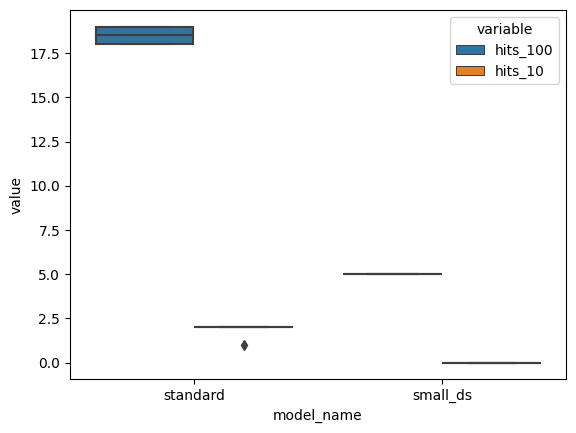

In [35]:
import seaborn as sns
sns.boxplot(pd.melt(hits_df, id_vars=['model_name']), x='model_name', y='value', hue='variable')
plot.set(xlabel='positive dataset', ylabel='score')
_ = plot.set_xticklabels(labels=['large', 'small'], rotation=0)

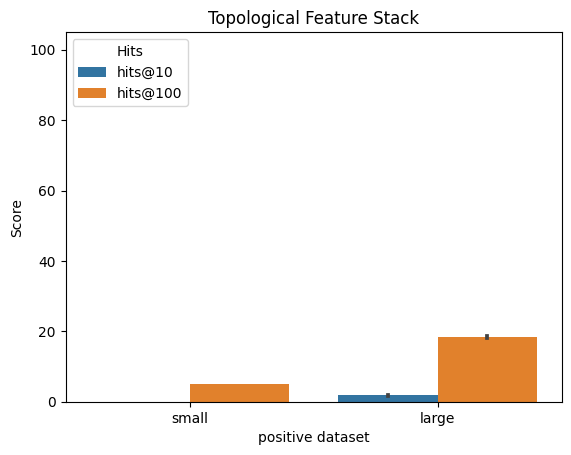

In [36]:
import seaborn as sns

y_lim= (0, 105)
y_label = 'Score'

plot_df = pd.melt(hits_df, id_vars=['model_name'])
variable_mapping = {'hits_100': 'hits@100', 'hits_10': 'hits@10'}
plot_df['Hits'] = plot_df['variable'].apply(lambda x: variable_mapping[x])
plot_df = plot_df.sort_values('Hits')
plot = sns.barplot(plot_df, x='model_name', y='value', hue='Hits', order=['small_ds', 'standard'])
sns.move_legend(plot, 'upper left')
plot.set(xlabel='positive dataset', ylabel=y_label)
plot.set_title(f'Topological Feature Stack')
plot.set_ylim(y_lim)
_ = plot.set_xticklabels(labels=['small', 'large'], rotation=0)

In [37]:
def plot_coeffs(rs):
    coef_df = pd.DataFrame({
        'coef_value': np.array([r['lr'].coef_ for r in rs]).flatten(),
        'coef_name': list(rs[0]['feature_names']) * len(rs),
    })

    plot = sns.boxplot(coef_df, x='coef_name', y='coef_value', order=coef_df.groupby('coef_name').mean().sort_values('coef_value').index.values)
    _ = plot.set_xticklabels(labels=plot.get_xticklabels(), rotation=90)
    
    return plot

<Axes: xlabel='coef_name', ylabel='coef_value'>

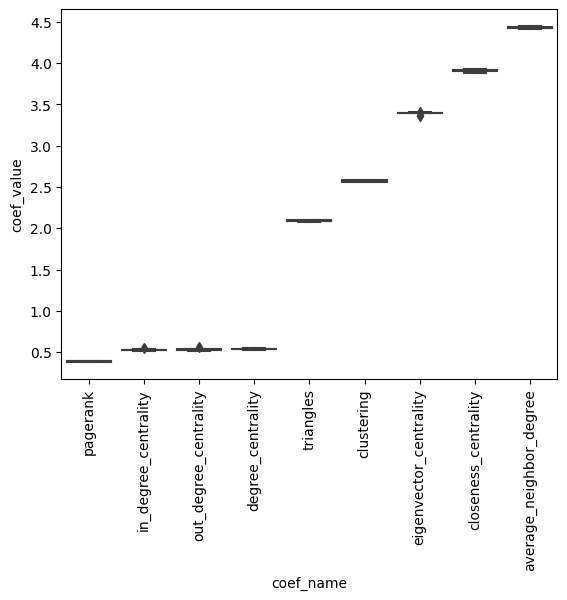

In [38]:
plot_coeffs(rs_standard)

<Axes: xlabel='coef_name', ylabel='coef_value'>

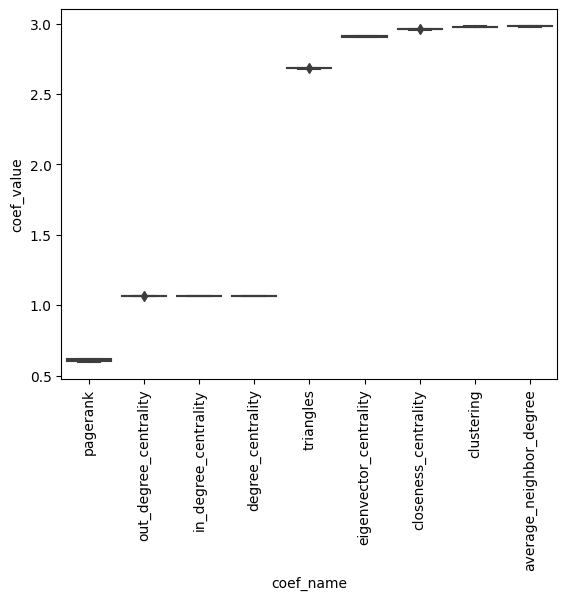

In [39]:
plot_coeffs(rs_small_ds)